In [96]:
## Vivaldi Rinaldi
## var287


## TIME SERIES ANALYSIS
## Goal: Find outliers, trends and periodicity in the MTA turnstyle data
## DATA:

MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.

The data was organized by Sina Kashuk at CUSP.

It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


## Task 4:

**Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**


## Task 5: Extra Credit

#### Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:

   - are there distinct clusters?
   - do they reflect the card type or station?


To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead:

observation = (observation -observation.mean()) / observation.std() each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

In [2]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import os

%pylab inline

from IPython.display import Image
from IPython.display import clear_output


Populating the interactive namespace from numpy and matplotlib


In [4]:
os.environ["PUIDATA"] = '%s/PUIdata'%os.getenv("HOME")
os.chdir(os.getenv("PUIDATA"))

In [4]:
! curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  30.2M      0 --:--:-- --:--:-- --:--:-- 30.3M


In [5]:
mta = np.load("MTA_Fare.npy")
mta.shape

(600, 23, 194)

## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations.

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - np.average(....weight=...) -. The sum and average functions take an axis argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

## Possibly useful functions

In [6]:
mta = mta.astype(float)
mta[mta == -1] = np.nan

print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [7]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. After that I create a date range (for example with pd.date_range()) in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i])) all time series, each station each ride type, look like this (pretty ugly)

In [8]:
time = pd.date_range(start='05/19/2010', periods=194, freq='W')
len(mta[4])

23

/nfshome/var287/.conda/envs/myPython3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


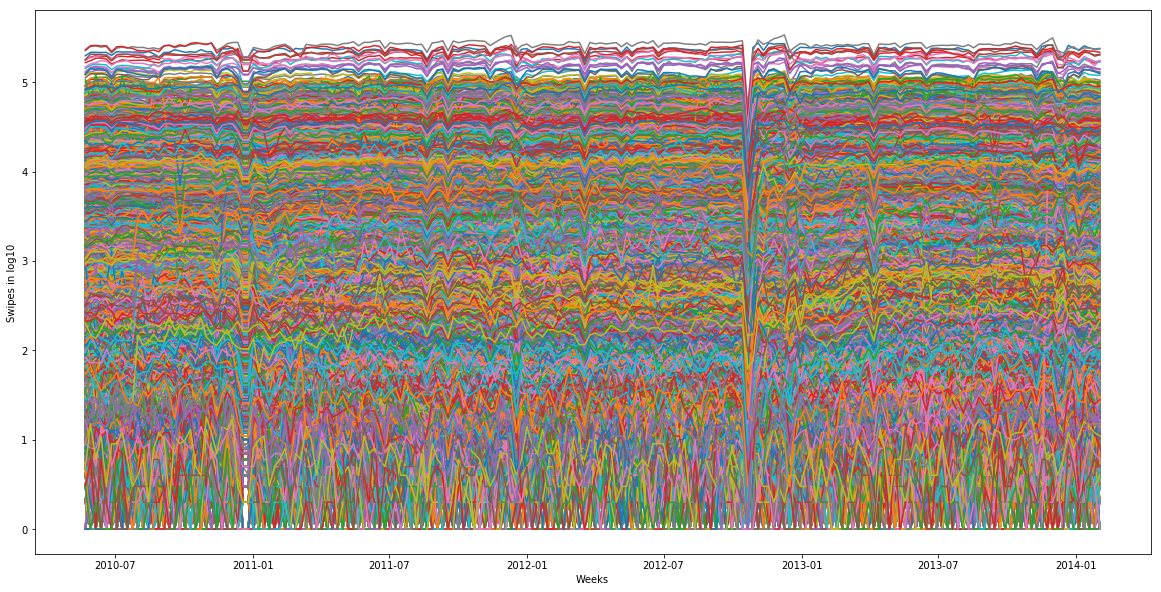

In [9]:
pl.figure(figsize=(20,10))
for i in range(len(mta)):
    for j in range(23):
        pl.plot(time, np.log10(mta[i][j]))
        pl.xlabel('Weeks')
        pl.ylabel('Swipes in log10')

Figure 1: Time series for all ride types and all stations in semi-log space

## 4. Fourier transform

from the numpy package you will nees only the np.fft.rfft() to take the fourier transform and
 np.fft.rfftfreq() to create a meaningful x axis


In [10]:
N = 194
mtaRides = mta.astype(float)

mtaRides[mtaRides == -1.0000e+00] = 'nan'
mtaRides= np.nan_to_num(mtaRides)
mtaRides = mtaRides.astype(int)


mtaRides = mtaRides.sum(axis=1)
mtaRides.shape

(600, 194)

/nfshome/var287/.conda/envs/myPython3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/nfshome/var287/.conda/envs/myPython3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


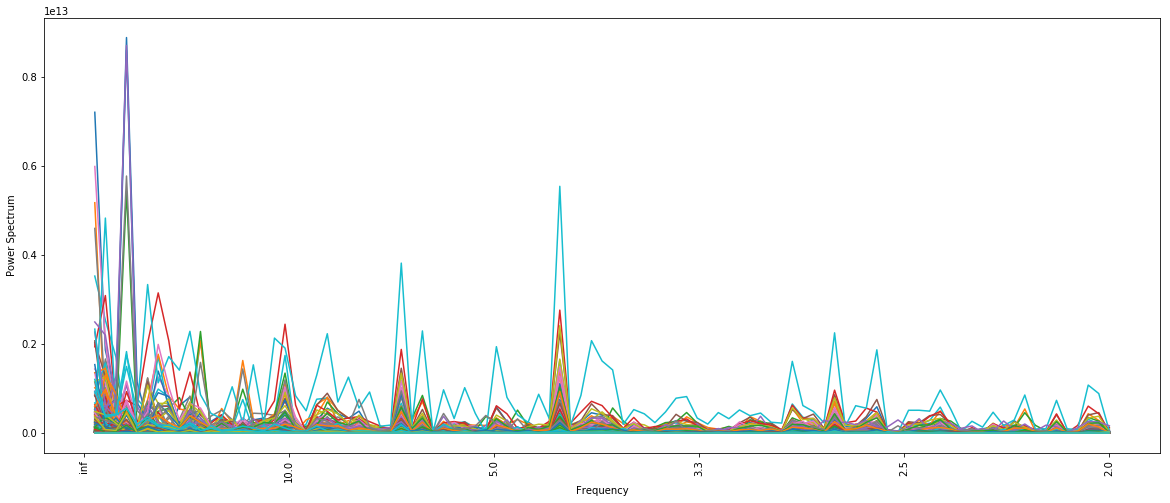

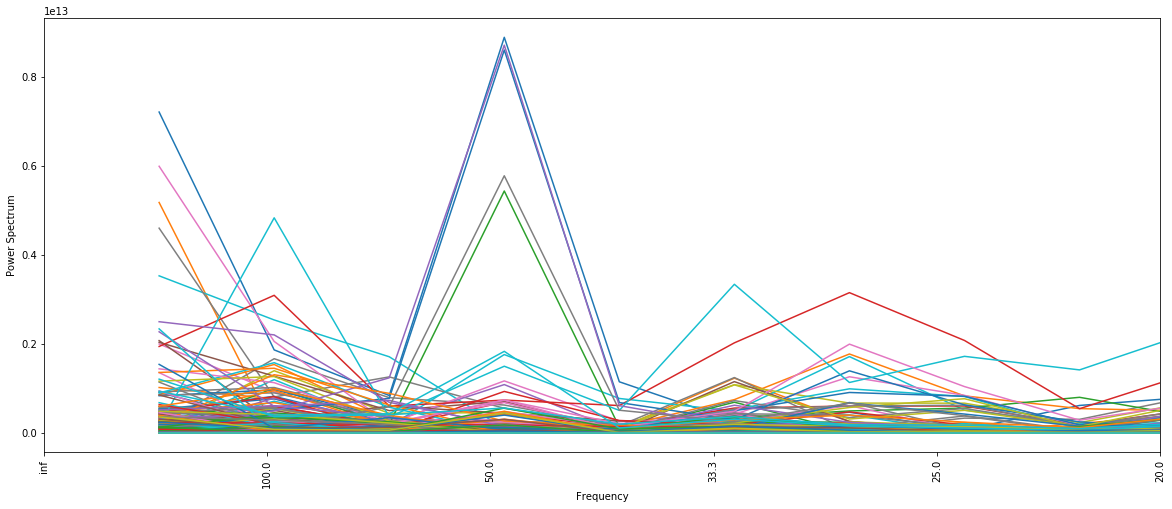

In [11]:
# plot station periodicity
fig = pl.figure(figsize=(20,8))
ax = fig.add_subplot(111)

for i in range(len(mtaRides)):
    f = np.abs(np.fft.rfft(mtaRides[i]))**2

    ax.plot(np.fft.rfftfreq(len(mtaRides[i]), 1.0)[1:], (f[1:]), '-')
    ax.set_xticklabels(["%.1f"%(1/f) for f in ax.get_xticks()], rotation=90)

    pl.xlabel("Frequency")
    pl.ylabel("Power Spectrum");  
    
    
    
fig = pl.figure(figsize=(20,8))
ax = fig.add_subplot(111)
for i in range(len(mtaRides)):
    f = np.abs(np.fft.rfft(mtaRides[i]))**2

    ax.plot(np.fft.rfftfreq(len(mtaRides[i]), 1.0)[1:], (f[1:]), '-')
    ax.set_xticklabels(["%.1f"%(1/f) for f in ax.get_xticks()], rotation=90)
    
    pl.xlim(0, .05)
    pl.xlabel("Frequency")
    pl.ylabel("Power Spectrum");  

Figure 2: Fourier Transformation of MTA data wihcih shows a peak at around 50 weeks, which is near to about a year. This finding shows a prominent yearly trend.

## 4 stations with prominent periodic trend

In [91]:
1 / 52

0.019230769230769232

In [93]:
freq = np.fft.rfftfreq(len(mtaRides[1]), 1.0)
freq

array([0.        , 0.00515464, 0.01030928, 0.01546392, 0.02061856,
       0.0257732 , 0.03092784, 0.03608247, 0.04123711, 0.04639175,
       0.05154639, 0.05670103, 0.06185567, 0.06701031, 0.07216495,
       0.07731959, 0.08247423, 0.08762887, 0.09278351, 0.09793814,
       0.10309278, 0.10824742, 0.11340206, 0.1185567 , 0.12371134,
       0.12886598, 0.13402062, 0.13917526, 0.1443299 , 0.14948454,
       0.15463918, 0.15979381, 0.16494845, 0.17010309, 0.17525773,
       0.18041237, 0.18556701, 0.19072165, 0.19587629, 0.20103093,
       0.20618557, 0.21134021, 0.21649485, 0.22164948, 0.22680412,
       0.23195876, 0.2371134 , 0.24226804, 0.24742268, 0.25257732,
       0.25773196, 0.2628866 , 0.26804124, 0.27319588, 0.27835052,
       0.28350515, 0.28865979, 0.29381443, 0.29896907, 0.30412371,
       0.30927835, 0.31443299, 0.31958763, 0.32474227, 0.32989691,
       0.33505155, 0.34020619, 0.34536082, 0.35051546, 0.3556701 ,
       0.36082474, 0.36597938, 0.37113402, 0.37628866, 0.38144

The closest to 1/52 frequency is 0.020, therefore we can isolate based on the 5th (4 in python) value of the array

In [86]:
#creating a list with the value of every station at this frequency
alist = []
for i in range(len(mtaRides)): 
    pers = np.abs(np.fft.rfft(mtaRides[i]))**2
    alist.append(pers[4])

In [89]:
station_max = np.argsort(-np.array(alist))[1:5]
station_max

array([194, 150, 327,  32])

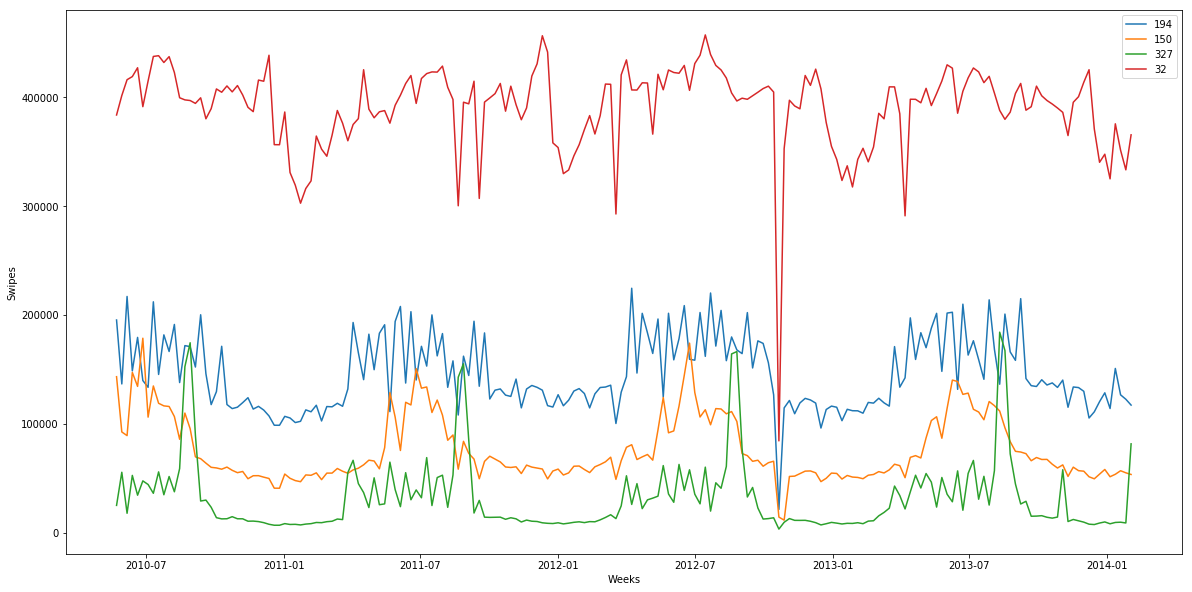

In [90]:
pl.figure(figsize=(20,10))
for i in station_max:
    pl.plot(time, mtaRides[i], label = str(i))
    pl.xlabel('Weeks')
    pl.ylabel('Swipes')
    pl.legend()

Figure 3: The 4 stations with prominent annual trend which show seasonality effect of rides. Rides significantly decreased during winter and increases in the summer.